# Clasificación de Texto con BERT y Hugging Face

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Ohtar10/icesi-advanced-dl/blob/main/Unidad%203%20-%20Transformers/text-classification-with-hf.ipynb)

En este notebook implementaremos un clasificador de noticias en español utilizando transformers pero ya basandonos en un modelo pre-entrenado tipo Bidirectional Encoder Representation from Transformers o BERT por sus siglas y disponible en Hugging Face Hub. El propósito de esta tarea es aprender a utilizar modelos pre-entrenados que por si mismos, sería sumamente costoso entrenar desde cero, tanto por el poder de computo como la disponibilidad de datos de entrenamiento. Entonces gran parte de la labor ya ha sido realizada por nosotros. Nuestra tarea ahora es especializar el modelo en la tarea que tenemos a la mano.

En esta ocasión, vamos a apartarnos de Pytorch Lightning y harémos uso extensivo de la herramientas de Hugging Face, las cuales están especialmente desarrolladas para este tipo de tareas, incluyendo la interacción con modelos pre-entrenados.

#### Referencias
- Dataset: https://huggingface.co/datasets/MarcOrfilaCarreras/spanish-news
- [BETO: Spanish BERT](https://huggingface.co/dccuchile/bert-base-spanish-wwm-cased)
- [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](http://arxiv.org/abs/1810.04805)
- [Natural Language Processing with Transformers: Building Language Applications With Hugging Face](https://www.amazon.com/Natural-Language-Processing-Transformers-Applications/dp/1098103246)
- [Hugging Face Transformers](https://huggingface.co/docs/transformers/v4.41.3/en/index)
- [Hugging Face Accelerate](https://huggingface.co/docs/accelerate/index)
- [Hugging Face Evaluate](https://huggingface.co/docs/evaluate/v0.4.0/en/index)
- [Hugging Face Datasets](https://huggingface.co/docs/datasets/v2.19.0/en/index)

In [1]:
import pkg_resources
import warnings

warnings.filterwarnings('ignore')

installed_packages = [package.key for package in pkg_resources.working_set]
IN_COLAB = 'google-colab' in installed_packages

In [2]:
!test '{IN_COLAB}' = 'True' && wget  https://github.com/Ohtar10/icesi-advanced-dl/raw/main/Unidad%203%20-%20Transformers/requirements.txt && pip install -r requirements.txt

### Cargando el dataset
Este es un dataset pequeño de articulos de noticias en idioma español con sus respectivas categorías. El dataset está disponible en el HuggingFace Hub y puede ser fácilmente descargado con la librería.

In [3]:
from datasets import load_dataset
import warnings
import os

warnings.filterwarnings("ignore")
dataset = load_dataset('MarcOrfilaCarreras/spanish-news', split='train')
dataset.set_format(type="pandas")
df = dataset.to_pandas()
df.head()

,language,category,newspaper,hash,text
0,es,play,de_lector_a_lector,1bcca6442ad224ca731b6e99b018ac219116e34c,Valladolid misteriosa es el título del nuevo l...
1,es,play,de_lector_a_lector,b387bc0a5ad68524c8aa5da489555ca41d5a3575,"El coraje de ser, de Mónica Cavallé, la aventu..."
2,es,play,de_lector_a_lector,cd4829e6999bb9e5cbb417daf6fd34b4fb8a86dc,"En la Tercera el francés, de Federico Supervie..."
3,es,play,de_lector_a_lector,467ba1276df60fdcfbe997d5f77e6136a028ee92,No fue Un fuego azul la primera novela de Pedr...
4,es,play,de_lector_a_lector,ef1dfb73db89b8ed5d0c66ed0ad03ab1d12a8157,"El tropiezo del tiempo, de Eduardo Álvarez Tuñ..."


In [4]:
import numpy as np

id2category = dict(enumerate(np.unique(df['category'])))
category2id = {v: k for k, v in id2category.items()}

df['category_id'] = df['category'].apply(lambda x: category2id[x])
df = df[['text', 'category', 'category_id']].sample(frac=1).reset_index(drop=True)
df.head()

,text,category,category_id
0,Jon Garay Necesitas ser suscriptor para acced...,astronomy,1
1,Tras conocerse el informe de la UCA que reveló...,politics,8
2,El PSOE sigue inmerso en el análisis de su deb...,politics,8
3,Muchos arrendadores no cumplen con los plazos ...,economy,2
4,El éxito comercial conseguido por el CUPRA Bor...,motor,6


En esta ocasión, vamos a explorar un poco más las características del dataset a manera ilustrativa.

Primero, observemos la distribución de las clases:

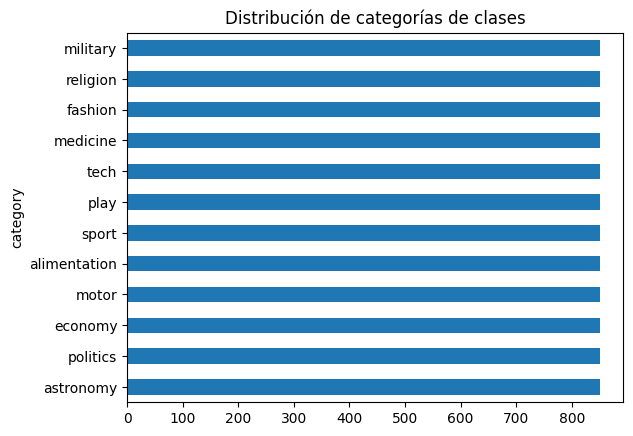

In [5]:
import matplotlib.pyplot as plt

df.category.value_counts(ascending=True).plot.barh()
plt.title('Distribución de categorías de clases')
plt.show()

In [169]:
df.category.value_counts()

category
sport           94
economy         92
tech            91
alimentation    91
fashion         89
military        87
religion        86
play            84
astronomy       78
medicine        78
politics        75
motor           75
Name: count, dtype: int64

Observamos que es un dataset balanceado.

Ahora observemos la dispersión de las palabras por cada categoría.

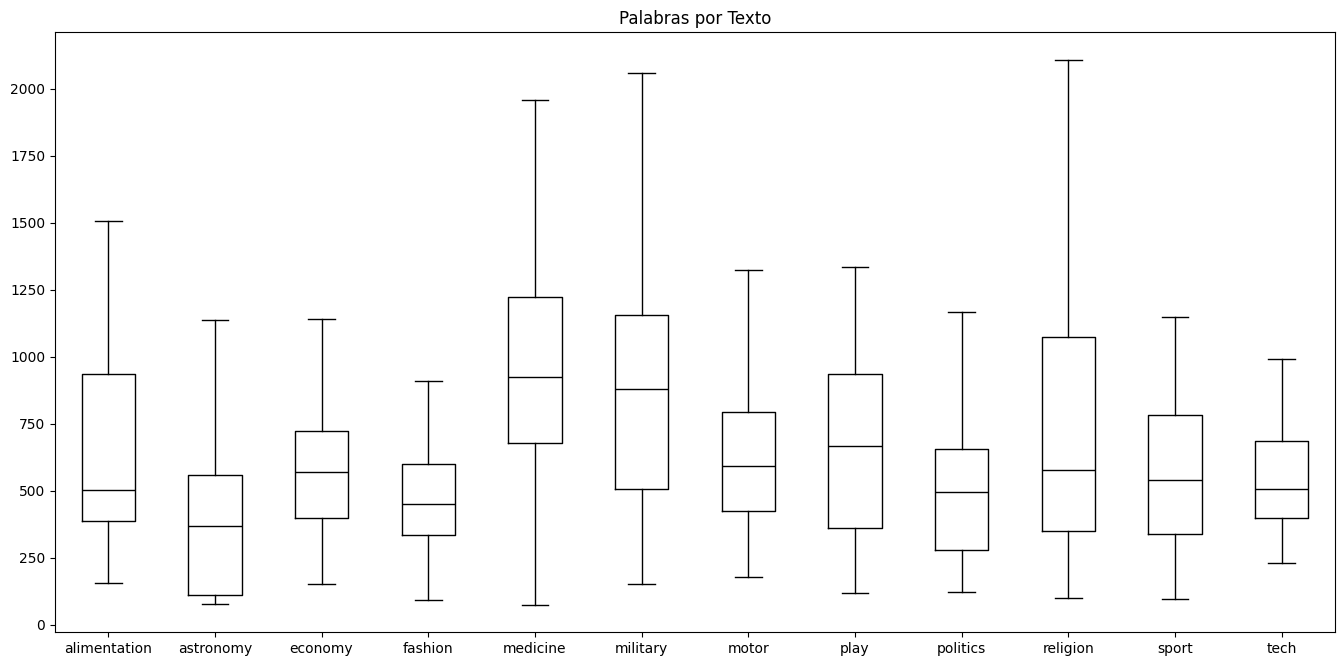

In [170]:
df['Palabras por Texto'] = df['text'].str.split().apply(len)
df.boxplot('Palabras por Texto', by='category', grid=False, showfliers=False, color='black', figsize=(16, 8))
plt.suptitle('')
plt.xlabel('')
plt.show()

Aquí observamos mayor diversidad. Observamos que algunas clases tienden a tener más palabras que otras, e incluso algunas tienen outliers en cuanto a la longitud de los textos. Sin embargo, como nuestra tarea es de clasificación según el texto y durante el entrenamiento vamos a manejar cadenas de tamaño fijo, lo que nos debería importar más que todo es la media/mediana entre todas las categorías.

In [173]:
df.groupby('category')['Palabras por Texto'].median()

category
alimentation    504.0
astronomy       367.5
economy         568.5
fashion         449.0
medicine        923.5
military        878.0
motor           593.0
play            667.0
politics        496.0
religion        576.0
sport           541.0
tech            506.0
Name: Palabras por Texto, dtype: float64

Como podemos observar, la mediana, que como media de tendencia central, tiende a ser más robusta que la media, nos indica que la longitud mediana de los textos entre todas las categorías tiende a rondar por las $\approx500$ palabras. Entonces utilizaremos una longitud de texto acorde durante nuestro entrenamiento.

In [7]:
dataset.reset_format()

### Definiendo el Tokenizer

Como la idea en este notebook es la de re-utilizar modelos pre-entrenados, algo a tener en cuenta es que para que esto funcione correctamente, debemos **siempre** utilizar el mismo tokenizador que se usó para entrenar el modelo. Recordemos que el tokenizador asigna un código a cada token del vocabulario, y durante la creación de los embeddings, el modelo asume esto como entrada, por lo que su usamos otro tokenizador, el modelo va a ser incapaz de derivar las relaciones semánticas apropiadas.

Para esta tarea, haremos uso de un modelo BERT pre-entrenado en corpus del idioma español. El modelo puede ser encontrado [aquí](https://huggingface.co/dccuchile/bert-base-spanish-wwm-cased), es un modelo entrenado por el [Departamento de Ciencias de la Computación de la Universidad de Chile](https://www.dcc.uchile.cl), el cual según los autores, fue entrenado en un gran corpus de idioma español por lo que resulta un buen candidato para la tarea en cuestión.

In [8]:
from transformers import AutoTokenizer

model_ckpt = "dccuchile/bert-base-spanish-wwm-cased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Ahora sometamos a prueba el tokenizador con la misma frase del notebook anterior.

In [83]:
tokenizer.pad_token = '[PAD]'
tokenizer("hola mundo!!", max_length=10, truncation=True, padding='max_length').tokens()

['[CLS]',
 'hola',
 'mundo',
 '!',
 '!',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

Algo interesante, este tokenizador, por lo menos para las palabras de esta frase de prueba, no separa en tokens distintos estas palabras, esto es justamente la razón por la cual no deberíamos usar un tokenizador diferente con un modelo pre-entrenado, habríamos obtenido tokens diferentes y el modelo no lograría interpretar la semantica como se espera.

Ahora, observemos su vocabulario.

In [10]:
tokenizer.vocab_size

31002

Tenemos $31002$ tokens, es una cantidad inferior que el modelo manual que intentamos en la lección anterior, pero lo suficientemente amplio para una tarea de NLP.

Ahora, observemos otros parámetros del tokenizador.

In [11]:
tokenizer.model_max_length

512

In [12]:
tokenizer.model_input_names

['input_ids', 'token_type_ids', 'attention_mask']

Primero, observamos que el tokenizador por defecto maneja un tamaño de secuencia de $512$, convenientemente al rededor de la misma longitud mediana de nuestro dataset, por lo que resulta perfecto para nuestro caso de uso. Finalmente, observamos sus salidas, las cuales serán las entradas a nuestro modelo. Como ya debemos saber, `input_ids` son los indices de los tokens y `attention_mask` es la máscara de atención cuando tenemos tokens irrelevantes (como el padding) en la cadena.

## Usando un modelo BERT pre-entrenado sencillo

![](../assets/bert-architecture.png)
![](../assets/bert-tokenization.png)
Primero, vamos a probar con un modelo pre-entrenado sin mayor modificación a la capa de clasificación. Hugging Face ofrece una clase utilitaria para inicializar el modelo en modo de clasificación de secuencias, lo cual hará que convenientemente tengamos una capa o cabeza de clasificación en el modelo, justo con la cantidad de clases que definamos.

Recordemos que el modelo y el tokenizador deben pertenecer al mismo "paquete", por lo que invocamos a `from_pretrained` con el mismo id que al tokenizer.

Técnicamente hay dos formas de utilizar un modelo pre-entrenado:

1. Como Featurizer: Es decir, vamos a utilizar todas las capas de codificación del modelo **sin re-entrenarlas** o lo que sería lo mismo **congelandolas** haciendo que lo único que vayamos a entrenar sea el clasificador en si.
2. Fine Tuning: Es decir, dejar todas las capas entrenables y entrenar el modelo en su totalidad, a partir del checkpoint del modelo pre-entrenado, para nuestra tarea especifica.

### BERT pre-entrenado como featurizer (simple)

Una ventaja de este enfoque es que es menos costoso de entrenar, a nivel de recursos de computo, ya que no vamos a calcular gradientes para todas las capas sino para la capa de clasificación. Incluso, no es necesario que utilicemos deep learning para la clasificación final, podemos usar algoritmos clasicos, que parten de los embeddings producidos por el modelo pre-entrenado.

Otra ventaja es que debido a que puede ser mucho más rápido de entrenar que no solo un modelo desde cero, sino más rápido que fine tuning, nuevamente, porque ya no es necesario calcular gradientes para todo el modelo, sino solo para la capa de clasificación de nuestro interes.

In [148]:
import torch
from torchinfo import summary
from transformers import AutoModelForSequenceClassification

device = "cuda" if torch.cuda.is_available() else "cpu"
inputs = tokenizer("hola mundo!!!", max_length=10, truncation=True, padding='max_length', return_tensors='pt')

print(f"Input Shapes & Types:")
print({k: (v.shape, v.dtype) for k, v in inputs.items()})

model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=len(category2id)).to(device)

# Congelamos los pesos del modelo base para usarlo como featurizer solamente.
for param in model.base_model.parameters():
    param.requires_grad = False
    
  
input_sizes = [inputs['input_ids'].shape] * 3
input_types = [inputs['input_ids'].dtype] * 3
with torch.no_grad():
    print(summary(model, input_size=input_sizes, dtypes=input_types, col_names=['input_size', 'output_size', 'num_params', 'trainable']))



Input Shapes & Types:
{'input_ids': (torch.Size([1, 10]), torch.int64), 'token_type_ids': (torch.Size([1, 10]), torch.int64), 'attention_mask': (torch.Size([1, 10]), torch.int64)}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Layer (type:depth-idx)                                       Input Shape               Output Shape              Param #                   Trainable
BertForSequenceClassification                                [1, 10]                   [1, 12]                   --                        Partial
├─BertModel: 1-1                                             [1, 10]                   [1, 768]                  --                        False
│    └─BertEmbeddings: 2-1                                   --                        [1, 10, 768]              --                        False
│    │    └─Embedding: 3-1                                   [1, 10]                   [1, 10, 768]              (23,809,536)              False
│    │    └─Embedding: 3-2                                   [1, 10]                   [1, 10, 768]              (1,536)                   False
│    │    └─Embedding: 3-3                                   [1, 10]                   [1, 10, 768]              (393,216)  

Observamos que el modelo tiene una capa `BertModel` que corresponde al modelo pre-entrenado y finaliza con una capa lineal que sería nuestro clasificador, esta es una capa proporcionada para nosotros al momento de inicializar el modelo. Además, observamos que solamente la capa lineal que hemos especificado tiene parámetros entrenables. Entonces, a pesar de que el modelo en si tiene más de 100 millones de parámetros, solamente menos de 10 mil son entrenables.

Observemos todos los modulos registrados en el modelo:

In [149]:
modules = [m for m, _ in model.named_modules()]
modules

['',
 'bert',
 'bert.embeddings',
 'bert.embeddings.word_embeddings',
 'bert.embeddings.position_embeddings',
 'bert.embeddings.token_type_embeddings',
 'bert.embeddings.LayerNorm',
 'bert.embeddings.dropout',
 'bert.encoder',
 'bert.encoder.layer',
 'bert.encoder.layer.0',
 'bert.encoder.layer.0.attention',
 'bert.encoder.layer.0.attention.self',
 'bert.encoder.layer.0.attention.self.query',
 'bert.encoder.layer.0.attention.self.key',
 'bert.encoder.layer.0.attention.self.value',
 'bert.encoder.layer.0.attention.self.dropout',
 'bert.encoder.layer.0.attention.output',
 'bert.encoder.layer.0.attention.output.dense',
 'bert.encoder.layer.0.attention.output.LayerNorm',
 'bert.encoder.layer.0.attention.output.dropout',
 'bert.encoder.layer.0.intermediate',
 'bert.encoder.layer.0.intermediate.dense',
 'bert.encoder.layer.0.intermediate.intermediate_act_fn',
 'bert.encoder.layer.0.output',
 'bert.encoder.layer.0.output.dense',
 'bert.encoder.layer.0.output.LayerNorm',
 'bert.encoder.layer.0

Observamos que la capa final es efectivamente el clasificador. Ahora hagamos una prueba pasando un dummy input:

In [150]:
with torch.no_grad():
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model(**inputs)
print({k: v.shape for k, v in outputs.items()})

{'logits': torch.Size([1, 12])}


In [151]:
outputs

SequenceClassifierOutput(loss=None, logits=tensor([[-0.0792,  0.1481, -0.0138, -0.0293, -0.0857,  0.1632,  0.0180, -0.0194,
         -0.1558,  0.0228, -0.0831, -0.1927]], device='cuda:0'), hidden_states=None, attentions=None)

In [152]:
model.classifier

Linear(in_features=768, out_features=12, bias=True)

Observamos que tras invocar el modelo, en efecto, obtenemos una salida de 12 dimensiones, correspondientes al número de clases.

Ahora preparemos los datos para el entrenamiento.

Hugging Face Datasets convenientemente implementa una función para hacer el train-test splig en nuestro dataset y automáticamente creará nuevas llaves en el mismo para diferenciarlo.

In [153]:
training_dataset = dataset.train_test_split(train_size=0.8)
validation_dataset = training_dataset['test'].train_test_split(train_size=0.5)

In [154]:
from datasets.dataset_dict import DatasetDict

new_dataset = DatasetDict({
    'train': training_dataset['train'],
    'val': validation_dataset['train'],
    'test': validation_dataset['test'],
})
new_dataset

DatasetDict({
    train: Dataset({
        features: ['language', 'category', 'newspaper', 'hash', 'text'],
        num_rows: 8160
    })
    val: Dataset({
        features: ['language', 'category', 'newspaper', 'hash', 'text'],
        num_rows: 1020
    })
    test: Dataset({
        features: ['language', 'category', 'newspaper', 'hash', 'text'],
        num_rows: 1020
    })
})

Tenemos nuestros tres conjuntos, sin embargo, esto es la información cruda, debemos preparar los datos para el modelo, lo gual incluye tokenizar y convertir las categorías a ids. Preparamos entonces unas funciones utilitarias.

In [155]:
def preprocess_function(max_len):
    def _preprocess_function(examples):
        return tokenizer(examples['text'], max_length=max_len, truncation=True, padding='max_length')
    return _preprocess_function

def tokenize(max_len: int = 8):
    def _tokenize(batch):
        return tokenizer(batch['text'], max_length=max_len, truncation=True, padding='max_length')
    return _tokenize

def category_names_2_ids(batch):
    batch['label'] = category2id[batch['category']]
    return batch


Y procedemos a invocarlas. Nótese que para la tokenización, estamos forzando a que las cadenas sean de 512 tokens, según el análisis que hemos hecho anteriormente.

In [156]:
tokenized_dataset = new_dataset.map(preprocess_function(max_len=512), batched=True)
tokenized_dataset = tokenized_dataset.map(category_names_2_ids)
tokenized_dataset

Map:   0%|          | 0/8160 [00:00<?, ? examples/s]

Map: 100%|██████████| 1020/1020 [00:00<00:00, 11995.35 examples/s]


DatasetDict({
    train: Dataset({
        features: ['language', 'category', 'newspaper', 'hash', 'text', 'input_ids', 'token_type_ids', 'attention_mask', 'label'],
        num_rows: 8160
    })
    val: Dataset({
        features: ['language', 'category', 'newspaper', 'hash', 'text', 'input_ids', 'token_type_ids', 'attention_mask', 'label'],
        num_rows: 1020
    })
    test: Dataset({
        features: ['language', 'category', 'newspaper', 'hash', 'text', 'input_ids', 'token_type_ids', 'attention_mask', 'label'],
        num_rows: 1020
    })
})

#### Entrenamiento

Ahora procederemos al entrenamiento. Aquí harémos uso de las API de HuggingFace directamente.

In [157]:
from transformers import Trainer, TrainingArguments
from typing import Dict, Any
import evaluate

# Definimos la función métrica de calidad
accuracy = evaluate.load("accuracy")

def compute_metrics(pred) -> Dict[str, Any]:
    """compute metrics

    Esta función será invocada en
    cada epoca y la utilizaremos para
    calcular la métrica de calidad.
    """ 
    labels = pred.label_ids 
    preds = pred.predictions.argmax(-1) 
    # Retorna un diccionario como {'nombre-metrica': valor}
    acc = accuracy.compute(predictions=preds, references=labels)
    return acc


batch_size = 8 if IN_COLAB else 4
logging_steps = len(tokenized_dataset['train']) // batch_size
# Definimos los parámetros globales de entrenamiento
training_args = TrainingArguments(
    output_dir='./hf',
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_eval_batch_size=batch_size,
    per_device_train_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    disable_tqdm=False,
    logging_steps=logging_steps
)

# Y definimos el entrenador, especificando el modelo, datasets y el tokenizador
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['val'],
    tokenizer=tokenizer
)

Con esto nos basta para ejecutar el entrenamiento:

In [158]:
%%time
trainer.train()

 50%|█████     | 2040/4080 [03:34<03:41,  9.22it/s]

{'loss': 2.2785, 'grad_norm': 7.424057960510254, 'learning_rate': 1e-05, 'epoch': 1.0}



 50%|█████     | 2040/4080 [04:01<03:41,  9.22it/s]

{'eval_loss': 2.0742106437683105, 'eval_accuracy': 0.7313725490196078, 'eval_runtime': 26.5389, 'eval_samples_per_second': 38.434, 'eval_steps_per_second': 9.609, 'epoch': 1.0}


100%|██████████| 4080/4080 [07:46<00:00,  9.22it/s]  

{'loss': 2.0121, 'grad_norm': 4.705126762390137, 'learning_rate': 0.0, 'epoch': 2.0}



100%|██████████| 4080/4080 [08:13<00:00,  9.22it/s]

{'eval_loss': 1.9427815675735474, 'eval_accuracy': 0.7823529411764706, 'eval_runtime': 26.7366, 'eval_samples_per_second': 38.15, 'eval_steps_per_second': 9.537, 'epoch': 2.0}


100%|██████████| 4080/4080 [08:14<00:00,  8.26it/s]

{'train_runtime': 494.241, 'train_samples_per_second': 33.02, 'train_steps_per_second': 8.255, 'train_loss': 2.145275519875919, 'epoch': 2.0}
CPU times: user 8min 10s, sys: 4.91 s, total: 8min 15s
Wall time: 8min 14s


TrainOutput(global_step=4080, training_loss=2.145275519875919, metrics={'train_runtime': 494.241, 'train_samples_per_second': 33.02, 'train_steps_per_second': 8.255, 'total_flos': 4294357961932800.0, 'train_loss': 2.145275519875919, 'epoch': 2.0})

Algo importante a resaltar es que fueron necesarias solo 2 iteraciones para alcanzar un ta tasa de correctitud $\approx 79%$, algo que con el modelo de transformers crudo nos costó muchas más iteraciones. Esto demuestra la importancia de partir de modelos pre-entrenados para este tipo de tareas.

Una ventaja adicional de Hugging Face transformers, es que publica automáticamente el progreso del entrenamiento a tensorboard, en el directorio que hemos especificado. Observemos entonces el proceso de entrenamiento:

In [113]:
%load_ext tensorboard

In [115]:
%tensorboard --logdir hf/runs

Reusing TensorBoard on port 6006 (pid 249533), started 0:00:06 ago. (Use '!kill 249533' to kill it.)

Y ahora evaluemos el modelo en el conjunto de prueba:

In [116]:
model.eval()
trainer.evaluate(tokenized_dataset['test'])

100%|██████████| 255/255 [00:23<00:00, 10.72it/s]


{'eval_loss': 1.9222784042358398,
 'eval_accuracy': {'accuracy': 0.8},
 'eval_runtime': 23.9368,
 'eval_samples_per_second': 42.612,
 'eval_steps_per_second': 10.653,
 'epoch': 2.0}

Hemos alcanzado una correctitud del $\approx 80\%$, lo cual, nuevamente, en comparación con el modelo de transformers crudo nos costó muchisimo más lograr.

### Haciendo uso del modelo
Ahora, hagamos predicciónes con el modelo y observemos los resultados.

In [124]:
predictions = trainer.predict(tokenized_dataset['test'])
predictions

100%|██████████| 255/255 [00:25<00:00, 10.13it/s]


PredictionOutput(predictions=array([[-0.1759461 ,  0.03346141, -0.31834364, ..., -0.4287671 ,
        -0.27118292, -0.43549633],
       [-0.32801855, -0.29997566, -0.08530736, ..., -0.64627326,
        -0.54211295,  0.34910655],
       [-0.5921599 , -0.42809874, -0.40451598, ...,  0.00901892,
        -0.20639794, -0.49397892],
       ...,
       [-0.6039256 , -0.11674692, -0.14230804, ...,  0.14269981,
        -0.06863043, -0.616503  ],
       [-0.04611844, -0.29109478, -0.22758298, ..., -0.28031257,
         0.03396798, -0.03944831],
       [-0.30645755, -0.4548075 ,  0.3070608 , ..., -0.37898403,
        -0.53923965,  0.07778741]], dtype=float32), label_ids=array([ 7, 11,  2, ...,  5,  3,  6]), metrics={'test_loss': 1.9222784042358398, 'test_accuracy': {'accuracy': 0.8}, 'test_runtime': 25.303, 'test_samples_per_second': 40.311, 'test_steps_per_second': 10.078})

In [143]:
predicted_labels = np.argmax(predictions.predictions, axis=-1)
test_set = tokenized_dataset['test']
test_set = test_set.add_column('prediction_label', predicted_labels)
test_set = test_set.add_column('prediction', list(map(lambda label: id2category[label], predicted_labels)))
test_set

Dataset({
    features: ['language', 'category', 'newspaper', 'hash', 'text', 'input_ids', 'token_type_ids', 'attention_mask', 'label', 'prediction_label', 'prediction'],
    num_rows: 1020
})

In [144]:
columns = ['text', 'label', 'prediction_label', 'category', 'prediction']
test_set.set_format('pandas', columns=columns)
df = test_set.to_pandas()[columns]
df.style.set_table_styles(
    [
        {'selector': 'td', 'props': [('word-wrap', 'break-word')]}
    ]
)
df.head(15)

,text,label,prediction_label,category,prediction
0,El verano de 2023 está repleto de películas qu...,7,7,play,play
1,El OnePlus 12 se lleva filtrando prácticamente...,11,11,tech,tech
2,"El exministro y empresario José Lladó, preside...",2,8,economy,politics
3,Hoy se estrena en los cines El exorcista: Crey...,9,7,religion,play
4,Si hay algo que los italianos se toman especia...,0,0,alimentation,alimentation
5,Podcast: Play in new window | DownloadHoy conv...,1,1,astronomy,astronomy
6,"Un estudio paneuropeo sobre la concienciación,...",11,4,tech,medicine
7,Puede que quede muy poco para que 2023 llegue ...,7,7,play,play
8,Por Peter Pinedo 15 de febrero de 2024 / 07:03...,9,1,religion,astronomy
9,En la búsqueda de respuestas sobre nuestra exi...,1,1,astronomy,astronomy


Los resultados no lucen nada mal, aún se cometen un par de errores, pero de resto, parece bastante aceptable. Observemos los errores.

In [145]:
errors = df[df['label'] != df['prediction_label']]
errors.head(15)

,text,label,prediction_label,category,prediction
2,"El exministro y empresario José Lladó, preside...",2,8,economy,politics
3,Hoy se estrena en los cines El exorcista: Crey...,9,7,religion,play
6,"Un estudio paneuropeo sobre la concienciación,...",11,4,tech,medicine
8,Por Peter Pinedo 15 de febrero de 2024 / 07:03...,9,1,religion,astronomy
14,El Partido Socialista Obrero Español (PSOE) de...,8,2,politics,economy
15,Muchos acelerados de la pasión alonsera dispar...,6,10,motor,sport
20,La Unidad de Integridad del Atletismo no ha es...,10,1,sport,astronomy
21,"Fuente de la imagen, BBC World ServiceErbil, c...",9,8,religion,politics
30,Andrea TornielliEl cardenal secretario de Esta...,9,8,religion,politics
32,Car and Driver participa en varios programas d...,6,10,motor,sport


Los errores parece que son mucho más interesantes que en nuestro mdelo pasado.

Los errores parecen algo mucho más genuino, economía y política son categorías que tienen algo de superposición entre si, al igual que motor y deportes, según sea el caso.

## Usando una capa más especializada como clasificador

Quizás podemos hacerlo mejor, hemos observado que por defecto, cuando cargamos la clase, Hugging Face nos da un clasificador muy simple, solo una capa lineal. Pero podemos utilizar un clasificador más complejo que definamos nosotros. Esta técnica seguiría utilizando el resto del modelo como featurizer, pero ahora añadimos complejidad a la capa de clasificación en búsqueda de una mejor calidad en los resutlados.

Entonces, volvemos a cargar el modelo tal como hemos hecho antes:

In [159]:
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=len(category2id)).to(device)

for param in model.base_model.parameters():
    param.requires_grad = False
    
  
input_sizes = [inputs['input_ids'].shape] * 3
input_types = [inputs['input_ids'].dtype] * 3
with torch.no_grad():
    print(summary(model, input_size=input_sizes, dtypes=input_types, col_names=['input_size', 'output_size', 'num_params', 'trainable']))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Layer (type:depth-idx)                                       Input Shape               Output Shape              Param #                   Trainable
BertForSequenceClassification                                [1, 10]                   [1, 12]                   --                        Partial
├─BertModel: 1-1                                             [1, 10]                   [1, 768]                  --                        False
│    └─BertEmbeddings: 2-1                                   --                        [1, 10, 768]              --                        False
│    │    └─Embedding: 3-1                                   [1, 10]                   [1, 10, 768]              (23,809,536)              False
│    │    └─Embedding: 3-2                                   [1, 10]                   [1, 10, 768]              (1,536)                   False
│    │    └─Embedding: 3-3                                   [1, 10]                   [1, 10, 768]              (393,216)  

In [160]:
model.classifier

Linear(in_features=768, out_features=12, bias=True)

### Definimos un clasificador propio

Podemos definir cualquier tipo de clasificador que se nos ocurra, siempre que se ajuste a las entradas y salidas del clasificador existente. Vamos a utilizar por ejemplo la misma capa lineal que definimos en el notebook anterior:

In [161]:
import torch.nn as nn


classifier = nn.Sequential(
    nn.Linear(768, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 12),
    nn.LogSoftmax(dim=1)
)

# simplemente reemplazamos el clasificador existente por el nuestro:
model.classifier = classifier
with torch.no_grad():
    print(summary(model, input_size=input_sizes, dtypes=input_types, col_names=['input_size', 'output_size', 'num_params', 'trainable']))

Layer (type:depth-idx)                                       Input Shape               Output Shape              Param #                   Trainable
BertForSequenceClassification                                [1, 10]                   [1, 12]                   --                        Partial
├─BertModel: 1-1                                             [1, 10]                   [1, 768]                  --                        False
│    └─BertEmbeddings: 2-1                                   --                        [1, 10, 768]              --                        False
│    │    └─Embedding: 3-1                                   [1, 10]                   [1, 10, 768]              (23,809,536)              False
│    │    └─Embedding: 3-2                                   [1, 10]                   [1, 10, 768]              (1,536)                   False
│    │    └─Embedding: 3-3                                   [1, 10]                   [1, 10, 768]              (393,216)  

Observamos que nuestro modelo ya tiene más parámetros para entrenar, producto de nuestro nuevo clasificador.

Procedemos a definir nuevamente el entrenador.

In [162]:
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['val'],
    tokenizer=tokenizer
)

Y a entrenar el modelo

In [163]:
%%time

trainer.train()

 50%|█████     | 2040/4080 [03:42<03:43,  9.11it/s]

{'loss': 2.0531, 'grad_norm': 7.9846882820129395, 'learning_rate': 1e-05, 'epoch': 1.0}



 50%|█████     | 2040/4080 [04:08<03:43,  9.11it/s]

{'eval_loss': 1.483218789100647, 'eval_accuracy': 0.7852941176470588, 'eval_runtime': 26.7688, 'eval_samples_per_second': 38.104, 'eval_steps_per_second': 9.526, 'epoch': 1.0}


100%|██████████| 4080/4080 [07:50<00:00,  9.80it/s]  

{'loss': 1.346, 'grad_norm': 5.568023681640625, 'learning_rate': 0.0, 'epoch': 2.0}



100%|██████████| 4080/4080 [08:14<00:00,  9.80it/s]

{'eval_loss': 1.1355111598968506, 'eval_accuracy': 0.8313725490196079, 'eval_runtime': 24.8938, 'eval_samples_per_second': 40.974, 'eval_steps_per_second': 10.244, 'epoch': 2.0}


100%|██████████| 4080/4080 [08:16<00:00,  8.21it/s]

{'train_runtime': 496.8402, 'train_samples_per_second': 32.848, 'train_steps_per_second': 8.212, 'train_loss': 1.6995322433172488, 'epoch': 2.0}
CPU times: user 8min 12s, sys: 5.1 s, total: 8min 18s
Wall time: 8min 17s


TrainOutput(global_step=4080, training_loss=1.6995322433172488, metrics={'train_runtime': 496.8402, 'train_samples_per_second': 32.848, 'train_steps_per_second': 8.212, 'total_flos': 4320373635809280.0, 'train_loss': 1.6995322433172488, 'epoch': 2.0})

Y evaluamos el resultado:

In [164]:
model.eval()
trainer.evaluate(tokenized_dataset['test'])

100%|██████████| 255/255 [00:24<00:00, 10.53it/s]


{'eval_loss': 1.1573837995529175,
 'eval_accuracy': 0.8264705882352941,
 'eval_runtime': 24.36,
 'eval_samples_per_second': 41.872,
 'eval_steps_per_second': 10.468,
 'epoch': 2.0}

Hemos obtenido una ligera mejora en nuestro modelo, lo cual sugiere que nuestro clasificador más complejo contribuye a una mayor calidad de los resultados.

## Fine Tuning con BERT

Para terminar, ahora harémos fine tuning, es decir, vamos a dejar libres todas las capas del modelo base para que todas calculen gradiente y entrenen sobre nuestra tarea específica.

En este caso entonces no necesitamos modificar nada del modelo original, podemos instanciarlo y proceder directamente al entrenamiento:

In [165]:
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=len(category2id)).to(device)
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['val'],
    tokenizer=tokenizer
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [167]:
%%time
trainer.train()

 50%|█████     | 2040/4080 [11:54<12:11,  2.79it/s]

{'loss': 0.3499, 'grad_norm': 0.03925882652401924, 'learning_rate': 1e-05, 'epoch': 1.0}



 50%|█████     | 2040/4080 [12:20<12:11,  2.79it/s]

{'eval_loss': 0.3550916612148285, 'eval_accuracy': 0.9411764705882353, 'eval_runtime': 26.1445, 'eval_samples_per_second': 39.014, 'eval_steps_per_second': 9.753, 'epoch': 1.0}


100%|██████████| 4080/4080 [24:30<00:00,  1.92it/s]  

{'loss': 0.1276, 'grad_norm': 77.30023956298828, 'learning_rate': 0.0, 'epoch': 2.0}



100%|██████████| 4080/4080 [25:08<00:00,  1.92it/s]

{'eval_loss': 0.2835220694541931, 'eval_accuracy': 0.9509803921568627, 'eval_runtime': 37.9919, 'eval_samples_per_second': 26.848, 'eval_steps_per_second': 6.712, 'epoch': 2.0}


100%|██████████| 4080/4080 [25:13<00:00,  2.70it/s]

{'train_runtime': 1513.8263, 'train_samples_per_second': 10.781, 'train_steps_per_second': 2.695, 'train_loss': 0.2387611987544041, 'epoch': 2.0}
CPU times: user 25min 7s, sys: 7.64 s, total: 25min 14s
Wall time: 25min 14s


TrainOutput(global_step=4080, training_loss=0.2387611987544041, metrics={'train_runtime': 1513.8263, 'train_samples_per_second': 10.781, 'train_steps_per_second': 2.695, 'total_flos': 4294357961932800.0, 'train_loss': 0.2387611987544041, 'epoch': 2.0})

In [168]:
model.eval()
trainer.evaluate(tokenized_dataset['test'])

100%|██████████| 255/255 [00:36<00:00,  6.92it/s]


{'eval_loss': 0.3077944815158844,
 'eval_accuracy': 0.946078431372549,
 'eval_runtime': 37.012,
 'eval_samples_per_second': 27.559,
 'eval_steps_per_second': 6.89,
 'epoch': 2.0}

Hemos alcanzado una correctitud superior al $\approx 90\%$ en el conjunto de prueba!

Con fine tuning, todas las capas del modelo ajustarán sus parámetros en respuesta al proceso de entrenamiento, por lo que es natural que la calidad de los resultados se incremente significativamente. Sin embargo, no hay que abusar del fine tuning ya que tiende a hacer overfitting al conjunto con el que se entrena, por eso también es recomendable no entrenarlo demasiado.

## Conclusiones
- Trabajar con modelos pre-entrenados supone una mejora no solo en la calidad de los resultados, sino en los tiempos de entrenamiento y esfuerzo requerido para la labor.
- En general, particularmente con modelos de lenguaje, dado lo costoso que puede resultar su entrenamiento desde cero, a día de hoy es mejor empezar con un modelo pre-entrenado y hacer bien transfer learning o fine tuning.
- Implementar modelos nuevos tiene sentido cuando la tarea en cuestión es particularmente novedosa o definitivamente no se cuenta con un modelo pre-entrenado que por lo menos capture parte del contexto requerido para la tarea. Ejemplos de esto puede ser una tarea en un idioma para el cual no exista aún un modelo fundacional, o que los existentes hayan sido entrenados en un corpus limitado o sesgado a un campo de dominio por ejemplo, ciertamente sería difícil obtener resultados de buena calidad para un modelo de clasificación en el ámbito legal, partiendo de un modelo entrenado exclusivamente en el ámbito clínico.
- Dentro de las posibilidades de usar un modelo pre-entrenado en forma de transfer learning o fine tuning, si fine tuning es superior, porque molestarse con las otras formas? porque no siempre se va a contar con los recursos (datos, computo y tiempo) para hacer fine tuning, o por ejemplo, en el runtime objetivo no se cuenta con GPU, por lo que quizás sea más factible usar modelos clásicos. Cada situación merece analizarse para hallar el mejor modo a implementar.